# Image generation with HuggingFace transformers library
> **_IMPORTANT_** This Jupyter notebook is not intended to run on local machine in Ollama, but instead in GoogleColab

To run this notebook please go to [Google Colab](https://colab.research.google.com), chose File > Upload > and drag&drop this Notebook.

As a runtime we will be using free GPU runtime:
![colab-runtime.png](colab-runtime.png)

[HuggingFace Pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines) are the high-level API for using open-source models for inference tasks.

To access HuggingFace we would need to create [an API key on HuggingFace portal](https://huggingface.co/settings/tokens) and put it in the "Secrets" tab of the GoogleColab:
![colab-secrets.png](colab-secrets.png)

First we create a pipeline like
`my_pipeline = pipeline("name_of_the_task")`

And then we use it for inference
`result = my_pipeline(my_input)`

At the moment of writing this notebook there are the following available types of pipelines (first argument in `= pipeline(arg)` call):
|Task Name | Description|
| :------- | :-------- |
|audio-classification | Classifies audio inputs into categories|
|automatic-speech-recognition | Transcribes speech to text|
|depth-estimation | Estimates depth from images|
|document-question-answering | Answers questions based on document images|
|feature-extraction | Extracts features from text or other inputs|
|fill-mask | Fills in masked tokens in text|
|image-classification | Classifies images into categories|
|image-feature-extraction | Extracts features from images|
|image-segmentation | Segments images into regions|
|image-text-to-text | Generates text from image and text input|
|image-to-image | Generates images from input images|
|image-to-text | Generates text descriptions from images|
|keypoint-matching | Matches keypoints between images|
|mask-generation | Generates masks for image segmentation|
|object-detection | Detects objects in images|
|question-answering | Answers questions from text context|
|summarization | Summarizes text|
|table-question-answering | Answers questions from table data|
|text2text-generation | Generates text from text input|
|text-classification | Classifies text into categories|
|sentiment-analysis | Analyzes sentiment in text|
|text-generation | Generates text from prompts|
|text-to-audio | Generates audio from text|
|text-to-speech | Synthesizes speech from text|
|token-classification | Classifies tokens in text (e.g., NER)|
|ner | Named Entity Recognition (subset of token-classification)|
|translation | Translates text between languages|
|translation_xx_to_yy | Specific language-to-language translation (e.g., translation_en_to_fr)|
|video-classification | Classifies videos into categories|
|visual-question-answering | Answers questions about images|
|vqa | Visual Question Answering (alias for visual-question-answering)|
|zero-shot-classification | Classifies text without training examples|
|zero-shot-image-classification | Classifies images zero-shot|
|zero-shot-audio-classification | Classifies audio zero-shot|
|zero-shot-object-detection | Detects objects zero-shot|



First let's do some preparation: installing packages and checking runtime and HuggingFace API key

In [1]:
# Pip installs should come at the top line. First run might take quite some time, because it downloads all the libraries, but consecutive runs will be much faster
!pip install -q --upgrade datasets==4.4.1

import torch
import gc
from google.colab import userdata
from huggingface_hub import login
from transformers import pipeline
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from datasets import load_dataset
import soundfile as sf
from IPython.display import Audio

# Check if runtime is GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)
    if gpu_info.find('Tesla T4') >= 0:
        print("Success - Connected to a T4")
    else:
        print("NOT CONNECTED TO A T4")

# Get token to connect to HuggingFace
hf_token = userdata.get('HF_TOKEN')
if hf_token and hf_token.startswith("hf_"):
    print("HF key looks good so far")
else:
    print("HF key is not set - please click the key in the left sidebar")
login(hf_token, add_to_git_credential=True)

# Setup some text to work with
input_text = "The cedent has notified a substantial IBNR deterioration on its US casualty portfolio, primarily driven by social inflation and lengthening claim tails in excess-of-loss layers. The reinsurer’s quota share and stop-loss treaties are now expected to attach earlier than originally modelled, pushing the combined ratio well above 120 %. Retrocession capacity for 2026 renewals has already tightened significantly."

Sun Nov 30 14:36:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Text classification

In [2]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device="cuda")
result = classifier(input_text, candidate_labels=["technology", "reinsurance", "politics", "sport"])

for label, score in zip(result["labels"], result["scores"]):
    print(f"{label}: {score:.4f}")

Device set to use cuda


reinsurance: 0.7728
politics: 0.1108
technology: 0.0665
sport: 0.0499


## Text summarization

In [3]:
if 'classifier' in locals(): del classifier
gc.collect()
torch.cuda.empty_cache()

summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device="cuda")
result = summarizer(input_text, max_length=50, min_length=25, do_sample=False)
print(result[0]["summary_text"])

Device set to use cuda


The cedent has notified a substantial IBNR deterioration on its US casualty portfolio, primarily driven by social inflation and lengthening claim tails. The reinsurer’s quota share and stop-loss treaties are now expected to attach


## Text translation

In [4]:
if 'summarizer' in locals(): del summarizer
gc.collect()
torch.cuda.empty_cache()

translator = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es", max_length=1000, device="cuda")
result = translator(input_text)
print(result[0]['translation_text'])

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda


El cedent ha notificado un deterioro sustancial del IBNR en su cartera de víctimas estadounidenses, impulsado principalmente por la inflación social y el alargamiento de las colas de reclamo en capas de exceso de pérdida. Se espera que la cuota de cuota y los tratados de stop-loss del reasegurador se adhieran antes de lo que se modeló originalmente, empujando la relación combinada por encima del 120 %. La capacidad de retrocesión para las renovaciones de 2026 ya se ha endurecido significativamente.


## Text to Speech

In [5]:
if 'translator' in locals(): del translator
gc.collect()
torch.cuda.empty_cache()

synthesiser = pipeline("text-to-speech", model="suno/bark-small", device=0)
output = synthesiser(input_text)
Audio(output["audio"], rate=output["sampling_rate"])

Device set to use cuda:0
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


## Image generation

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/4 [00:00<?, ?it/s]

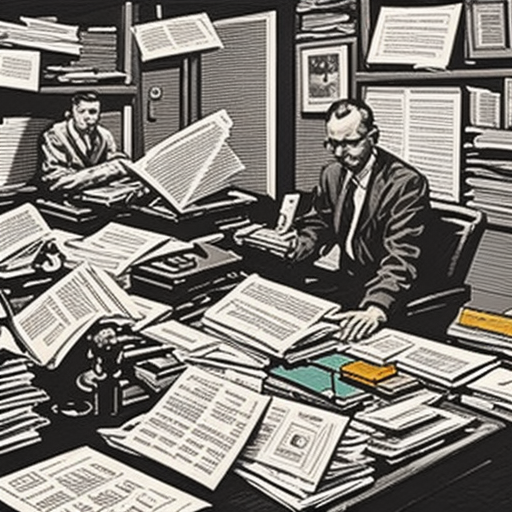

In [7]:
if 'synthesiser' in locals(): del synthesiser
gc.collect()
torch.cuda.empty_cache()

image_pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/sd-turbo")
image_pipeline.to("cuda")
prompt = "An actuary saves a business from bankrupting by taking all the risks"
image = image_pipeline(prompt=prompt, num_inference_steps=4, guidance_scale=0.0).images[0]
display(image)